In [21]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import abtem
import numpy as np
from abtem.core.axes import ParameterAxis
from abtem.core.backend import get_array_module
from abtem.core.utils import expand_dims_to_broadcast
from abtem.transform import (
     ArrayObjectTransform,
     CompositeArrayObjectTransform,
     WavesTransform,
)
import ase

abtem.config.set({"local_diagnostics.progress_bar": False});

# Extending *ab*TEM

In this tutorial, we describe how to extend *ab*TEM using some of the most fundamental and general concepts of the library. If you have an idea for how to extend *ab*TEM, you are welcome to contact us.

## The `ArrayObject` and `ArrayObjectTransform`

To run the multislice algorithm we describe the $xy$-part of a wave function on a grid as a 2D array or an ensemble of such wave functions as a multidimensional array with more than 2 dimensions. See our [appendix on ensembles](). We encapsulate the array in the `Waves` object, together with metadata such as the energy and real-space extent, ensembles of wave function will have additional metadata describing each ensemble axis. The `Waves` are an example of an `ArrayObject` which is the base class for any object in *ab*TEM represented by an array and some metadata. 

An `ArrayObject` is "mainly" described by a single array (NumPy, CuPy) representing almost all the memory requirements of the object, all `ArrayObject` can be lazy. The memory requirements of the metadata is assumed to negligible, and any lazily applied transformation applied to the array should be possible to apply immediately to metadata, the metadata keep enough just enough information to apply further transformations lazily.

In [34]:
atoms = abtem.orthogonalize_cell(ase.build.mx2(vacuum=2)) * (3, 2, 1)

frozen_phonons = abtem.FrozenPhonons(atoms, num_configs=32, sigmas=.1)

potential = abtem.Potential(frozen_phonons, sampling=0.05)

probe = abtem.Probe(energy=80e3, semiangle_cutoff=30)

None of the objects created above are examples of `ArrayObject`s. However, the `Probe` and `Potential` can be converted to the `Waves` and `PotentialArray` objects, which are subclasses of the `ArrayObject` base class.

We can run the `.build` method to create `Waves` from the `Probe`.

In [32]:
probe.grid.match(potential)

waves = probe.build()

waves

In [33]:
waves.array

dask.array<getitem, shape=(191, 221), dtype=complex64, chunksize=(191, 221), chunktype=numpy.ndarray>

The `Waves` and other `ArrayObjects` can be modified by applying an `ArrayObjectTransform`. 

In [30]:
aberrations = abtem.transfer.Aberrations(defocus= np.linspace(0, 100, 5), Cs=np.linspace(0, 1e6, 3))

aberrations.ensemble_shape

(5, 3)

In [31]:
defocused_waves = waves.apply_transform(ctf)

defocused_waves.array

dask.array<apply_transform, shape=(5, 3, 191, 221), dtype=complex64, chunksize=(5, 3, 191, 221), chunktype=numpy.ndarray>

In [22]:
scan = abtem.GridScan()



Cell([9.540000000000001, 11.01584313613806, 7.1899999999999995])

In [ ]:
scan = abtem.GridScan(start=(0,0), end=(1,1), )





The `WavesFactory` types (`Probe` and `PlaneWave`) works by applying a sequence of transforms to produce 

In the following we roll 

Behind the scenes most things are implemented as a type of `ArrayObjectTransform`

The `ArrayObjectTransform` is a general .

A transform takes an *ab*TEM `ArrayObject`. 

* Encapsulate code the modifies an array into a concept microscopists, but not necessarily expert programmers understand.
* A transform will modify the array of each member of the ensemble in the same way (broadcast in NumPy terminology).
* A transform is applied lazily to lazy `ArrayObjects` and eagerly to in-memory `ArrayObjects`
    * Chunks are automatically adjusted according

An important technical detail is that multiple `ArrayObjectTranform`s can be combined . This allows *ab*TEM to more efficiently 

without transdferring large amounts of data between processes



## A custom `WavesTranform`

A special subclass of `ArrayObjectTransform` is the `WavesTransform`. We demonstrate how to create a custom `WavesTransform` with an example of a transform that applies a phase shift to a wave function. We create an object called `PhaseShift` inheriting from the `WaveTransform`. Our new phase shift `WavesTransform` takes the argument `shift`, which should also be exposed as a public property. The `WavesTransform` _has_ to implement the `_calculate_new_array` method, which takes a `Waves` object and, unless further specifications are given as described below, should return a new array of the same shape and complex type as the array describing the input `Waves`.

We use the `get_array_module` function to make the our code agnostic to the array module. This function will return either the NumPy or the [CuPy](https://cupy.dev/) module, depending on the array type, thus enabling the code to work on GPU's without futher work.

In [4]:
class PhaseShift(WavesTransform):
    def __init__(self, shift):
        self._shift = shift
        super().__init__()

    @property
    def shift(self):
        return self._shift

    def _calculate_new_array(self, waves):
        xp = get_array_module(waves.array)

        new_array = waves.array * xp.exp(1.0j * self.shift)

        return new_array

We create some `Waves` describing a probe wave function.

In [5]:
import ase

atoms = ase.build.bulk("Au", cubic=True) * (2, 2, 1)

fp = abtem.FrozenPhonons(atoms, sigmas=0.1, num_configs=2)

potential = abtem.Potential(atoms, slice_thickness=1, sampling=0.05)

In [11]:
from __future__ import annotations

from functools import partial

from abtem.detectors import BaseDetector, WavesDetector
from abtem.multislice import multislice_and_detect, MultisliceTransform
from abtem.potentials.iam import BasePotential


probe = abtem.Probe(
    semiangle_cutoff=20,
    energy=300e3,
    #defocus=[10,20,30]
)

planewave = abtem.PlaneWave(
    #semiangle_cutoff=20,
    energy=300e3,
    #defocus=[10,20,30]
)

probe.grid.match(potential)
planewave.grid.match(potential)
#waves = probe.build().compute().ensure_lazy()

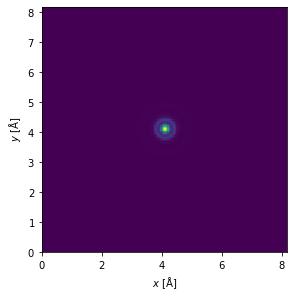

In [13]:
waves = probe.multislice(potential=potential)

waves.compute(scheduler="single-threaded").show()

In [44]:
#.compute().show(cbar=True, explode=True, common_color_scale=True)


m = MultisliceTransform(potential, WavesDetector())

waves.apply_transform(m).compute()



#m.ensemble_blocks(1).compute()
#waves.compute().show()

((0,),) [Atoms(symbols='Au16', pbc=True, cell=[8.16, 8.16, 4.08])]


In [107]:
[*[]]

[]

In [64]:
detector1 = abtem.PixelatedDetector()
detector2 = abtem.PixelatedDetector(max_angle="full")

aperture1 = abtem.transfer.Aberrations(C10=np.arange(2))
aperture2 = abtem.transfer.Aberrations(C10=np.arange(3))
scan = abtem.LineScan(start=(0,0), end=(3,3), gpts=3)


multislice = MultisliceTransform(potential, [detector1, detector2])

transform = CompositeArrayObjectTransform([aperture1])

In [89]:

new_array.compute()

array([[[0.9999999+1.3526098e-16j, 0.9999999+6.9709620e-17j,
         1.       +1.5415892e-15j, ..., 0.9999999-3.6058343e-16j,
         1.       -1.1100369e-15j, 1.       +8.2283359e-16j],
        [0.9999999-7.5051518e-16j, 0.9999999-8.1606648e-16j,
         1.       +9.2633492e-16j, ..., 0.9999999-9.7583765e-16j,
         1.       -1.8605521e-15j, 1.       -6.2942548e-17j],
        [0.9999999+1.7606445e-15j, 0.9999999+1.6950931e-15j,
         1.       +2.3554070e-15j, ..., 0.9999999+1.0006190e-15j,
         1.       +6.5060759e-16j, 1.       +2.4482170e-15j],
        ...,
        [1.       +1.2020707e-15j, 1.       +1.1365194e-15j,
         1.       +2.8789208e-15j, ..., 1.       +9.7674831e-16j,
         1.       +9.2033862e-17j, 1.       +1.8896433e-15j],
        [0.9999999-5.1739028e-16j, 0.9999999-5.8294163e-16j,
         1.       +1.7005037e-15j, ..., 0.9999999-1.2774158e-15j,
         1.       -1.6274272e-15j, 1.       +1.7018233e-16j],
        [0.9999999+1.3044170e-15j, 0.99999

In [61]:
import dask.array as da
from abtem.detectors import PixelatedDetector
from abtem.transfer import Aberrations, Aperture
from abtem.transform import CompositeArrayObjectTransform


detector1 = abtem.PixelatedDetector()
detector2 = abtem.PixelatedDetector(max_angle="full")

aperture1 = abtem.transfer.Aberrations(C10=np.arange(2))
aperture2 = abtem.transfer.Aberrations(C10=np.arange(3))
scan = abtem.LineScan(start=(0,0), end=(3,3), gpts=3)


multislice = MultisliceTransform(potential, [detector1, detector2])

t = CompositeArrayObjectTransform([multislice, aperture1, scan])

waves = probe.build()#.compute().ensure_lazy()

In [62]:

#waves = waves.compute()
#t.ensemble_axes_metadata
#waves = waves.apply_transform(t).compute(scheduler="single-threaded")

#waves.axes_metadata
measurements = waves.apply_transform(t).compute()
measurements[0].axes_metadata #compute().array.shape

type                 label           coordinates
-------------------  --------------  --------------------
FrozenPhononsAxis    Frozen phonons  -
ParameterAxis        C10 [Å]         0.00 1.00
ScanAxis             x [Å]           0.00 2.12 4.24
ReciprocalSpaceAxis  kx [1/Å]        -4.66 -4.41 ... 4.41
ReciprocalSpaceAxis  ky [1/Å]        -4.66 -4.41 ... 4.41

In [10]:
measurement = waves.apply_transform(detector).compute()

measurement

In [28]:
detector._out_type(waves)

NameError: name 'sss' is not defined

In [28]:
phase_shift._partition_args(2)

()

Our phase shift transform can be applied using the `apply_transform` method. 

In [29]:
phase_shift = PhaseShift(shift=np.pi / 2)

phase_shifted_waves = waves.apply_transform(phase_shift)

phase_shifted_waves.array

array([[-2.38705569e-21+2.71278668e-06j, -1.50832635e-21+2.70914367e-06j,
        -2.34941060e-21+2.69822231e-06j, ...,
        -2.46963761e-21+2.68004556e-06j, -3.27585289e-21+2.69822221e-06j,
        -2.11051384e-21+2.70914362e-06j],
       [ 6.98813415e-15+2.70914367e-06j,  6.97958617e-15+2.70550266e-06j,
         6.95396026e-15+2.69458729e-06j, ...,
         6.91132169e-15+2.67642058e-06j,  6.95395879e-15+2.69458719e-06j,
         6.97958550e-15+2.70550261e-06j],
       [ 1.39305051e-14+2.69822231e-06j,  1.39134760e-14+2.69458730e-06j,
         1.38624277e-14+2.68368996e-06j, ...,
         1.37774884e-14+2.66555339e-06j,  1.38624262e-14+2.68368985e-06j,
         1.39134752e-14+2.69458724e-06j],
       ...,
       [-2.07815783e-14+2.68004556e-06j, -2.07562015e-14+2.67642058e-06j,
        -2.06801376e-14+2.66555340e-06j, ...,
        -2.05535709e-14+2.64746728e-06j, -2.06801377e-14+2.66555329e-06j,
        -2.07562019e-14+2.67642053e-06j],
       [-1.39305097e-14+2.69822221e-06j, -1.

We stack the original and phase shifted `Waves` to show them.

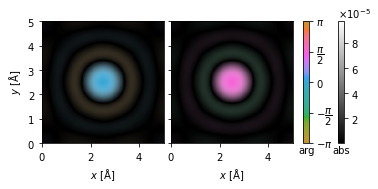

In [30]:
stacked_images = abtem.stack((waves, phase_shifted_waves)).complex_images()

stacked_images.show(
    explode=True,
    title="",
    cbar=True,
    common_color_scale=True,
);

### Including distributions of parameters

The `WavesTransform` leverages

In [7]:
class PhaseShift(WavesTransform):
    def __init__(self, shift):
        self._shift = self._validate_distribution(shift)
        super().__init__(distributions=("shift",))

    @property
    def shift(self):
        return self._shift

    @property
    def ensemble_axes_metadata(self):
        return self._axes_metadata_from_distributions(
            shift={"label": "phase shift", "units": "rad"}
        )

    def _calculate_new_array(self, waves):
        xp = get_array_module(waves.array)

        shift = xp.array(self.shift)

        shift, new_array = expand_dims_to_broadcast(shift, waves.array)

        new_array = new_array * xp.exp(1.0j * shift)

        return new_array

In [12]:
phase_shift = PhaseShift(shifts)

phase_shift._default_ensemble_chunks

('auto',)

In [9]:
shifts = np.linspace(-np.pi, np.pi, 4, endpoint=False)

phase_shift = PhaseShift(shifts)

phase_shifted_waves = waves.apply_transform(phase_shift)

NameError: name 'waves' is not defined

In [233]:
phase_shifted_waves.axes_metadata

type           label              coordinates
-------------  -----------------  --------------------
ParameterAxis  phase shift [rad]  -3.14 -1.57 ... 1.57
RealSpaceAxis  x [Å]              0.00 0.02 ... 4.98
RealSpaceAxis  y [Å]              0.00 0.02 ... 4.98

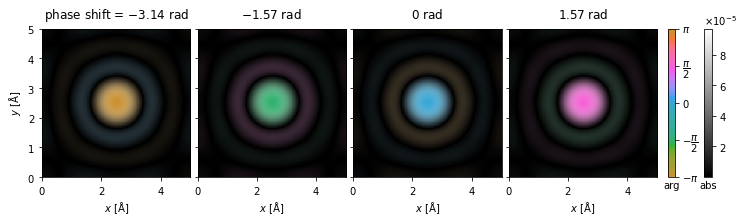

In [238]:
images = phase_shifted_waves.complex_images()

images.show(explode=True, cbar=True, common_color_scale=True, figsize=(12, 5));

### The `BaseAperture` transform

In [16]:
from abtem.transfer import BaseAperture, soft_aperture


class Vortex(BaseAperture):
    def __init__(
        self,
        quantum_number,
        semiangle_cutoff,
        energy=None,
        extent=None,
        gpts=None,
        sampling=None,
    ):
        self._quantum_number = quantum_number

        super().__init__(
            semiangle_cutoff=semiangle_cutoff,
            energy=energy,
            extent=extent,
            gpts=gpts,
            sampling=sampling,
        )

    @property
    def quantum_number(self):
        return self._quantum_number

    def _evaluate_from_angular_grid(self, alpha, phi):
        xp = get_array_module(alpha)

        semiangle_cutoff = self.semiangle_cutoff * 1e-3
        array = soft_aperture(alpha, phi, semiangle_cutoff, self.angular_sampling)

        phase = xp.exp(1.0j * phi * quantum_number)
        array = array * phase

        return array

In [17]:
class Vortex(BaseAperture):
    def __init__(
        self,
        quantum_number,
        semiangle_cutoff,
        energy=None,
        extent=None,
        gpts=None,
        sampling=None,
    ):
        self._quantum_number = self._validate_distribution(quantum_number)
        semiangle_cutoff = self._validate_distribution(semiangle_cutoff)

        super().__init__(
            energy=energy,
            semiangle_cutoff=semiangle_cutoff,
            extent=extent,
            gpts=gpts,
            sampling=sampling,
            distributions=("quantum_number", "semiangle_cutoff"),
        )

    @property
    def quantum_number(self):
        return self._quantum_number

    @property
    def ensemble_axes_metadata(self):
        return self._axes_metadata_from_distributions(
            quantum_number={
                "label": "quantum number",
                "units": "",
                "_tex_label": "$\ell$",
            },
            semiangle_cutoff={
                "label": "cutoff",
                "units": "mrad",
                "_tex_label": "$\\alpha_{\mathrm{cut}}$",
            },
        )

    def _evaluate_from_angular_grid(self, alpha, phi):
        xp = get_array_module(alpha)

        # calculate aperture
        semiangle_cutoff = xp.array(self.semiangle_cutoff) * 1e-3
        aperture = soft_aperture(alpha, phi, semiangle_cutoff, self.angular_sampling)

        # calculate phase factor
        quantum_number = xp.array(self.quantum_number)
        quantum_number, phi = expand_dims_to_broadcast(quantum_number, phi)
        phase = xp.exp(1j * phi * quantum_number)

        # multiply phase with
        phase, aperture = expand_dims_to_broadcast(
            phase, aperture, match_dims=[(-2, -1), (-2, -1)]
        )
        array = aperture * phase

        return array

In [19]:
vortex._partition_args()

(dask.array<array, shape=(3,), dtype=object, chunksize=(1,), chunktype=numpy.ndarray>,
 dask.array<array, shape=(2,), dtype=object, chunksize=(1,), chunktype=numpy.ndarray>)

In [18]:
vortex = Vortex(
    quantum_number=[1, 2, 4],
    semiangle_cutoff=[20, 30],
)

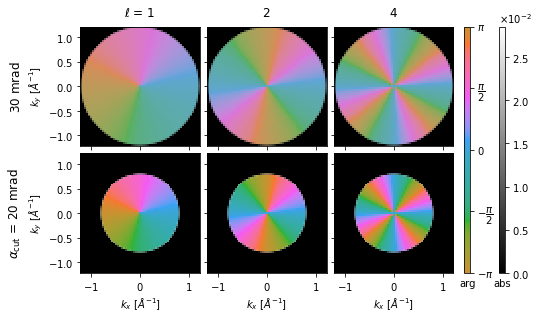

In [241]:
probe = abtem.Probe(energy=200e3, gpts=128, extent=25, aperture=vortex)

waves = probe.build((0, 0))

waves.diffraction_patterns(return_complex=True).crop(30).show(
    explode=True, cbar=True, common_color_scale=True, figsize=(8, 8)
);

### The `BaseDetector` transform

In [ ]:
blocks = phase_shift.ensemble_blocks(2)

blocks

In [ ]:
blocks.compute()

In [ ]:
transformed_waves.axes_metadata